# From raw neutron counts to volumetric soil moisture

For the time being, this notebook is a sandbox based on which library functions will be developed step by step.

In [1]:
import cosmicsense as cs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

In [2]:
# Display figures inline
%matplotlib inline
# Display figures as interactive (requires kernel restart)
#%matplotlib

## Read raw data

#### CRNS records

`crns_sample1.txt` containts raw CRNS neutron counts for a standard and a bare counter, as well as air pressure and temperature tie series.

In [3]:
# Sensor counts
crns = pd.read_csv("../../../data/crns_sample1.txt", sep="\t")
crns.columns = ["recnum", "datetime", "press", "temp", "relhum", "volt", "n1c", "n2c", "n1et", "n2et", "fileno", "id_flag"]
crns.datetime = pd.to_datetime(crns.datetime)
crns = crns.set_index("datetime")
crns.head()

,recnum,press,temp,relhum,volt,n1c,n2c,n1et,n2et,fileno,id_flag
datetime,,,,,,,,,,,
2010-09-17 12:22:42,1,1011.4,23.6,49.4,12.353,5,0,10,0,16,5
2010-09-17 12:23:00,2,1011.4,23.2,49.9,12.353,5,0,17,0,16,5
2010-09-17 12:24:00,3,1011.4,23.0,50.7,12.353,12,0,60,0,16,5
2010-09-17 12:25:00,4,1011.3,23.0,50.7,12.352,7,0,60,0,16,5
2010-09-17 12:26:00,5,1011.3,23.1,50.6,12.353,10,0,60,0,16,5


#### NMBD station data

`nmdb_corr.txt` contains reference (background) neutron counts from [NMDB](http://www.nmdb.eu/nest/), for stations `KIEL`, `KIEL2`, `ZUGSPITZE`, and `DRBS` (Dourbes, Belgium), from Jan 2010 to Feb 2019. 

In [4]:
# NMDB data
nmdb = pd.read_csv("../../../data/nmdb_corr.txt", sep=";", comment="#", na_values="   null")
nmdb.datetime = pd.to_datetime(nmdb.datetime)
nmdb = nmdb.set_index("datetime")
nmdb.head()

,DRBS,KIEL,KIEL2
datetime,,,
2010-01-01 00:00:00,115.620,182.344,NaN
2010-01-01 06:00:00,NaN,183.750,NaN
2010-01-01 12:00:00,NaN,182.454,NaN
2010-01-01 18:00:00,NaN,181.456,NaN
2010-01-02 00:00:00,115.643,180.778,NaN


## Quick view of the raw data

(734032.5157638888, 734441.9979166667)

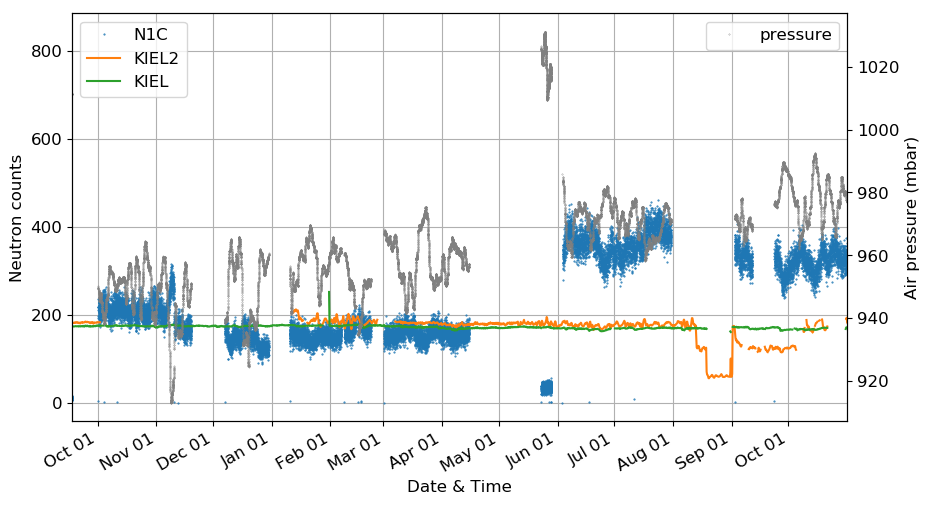

In [59]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(figsize=(10,6))

n1cpl = crns.n1c.plot(ax=ax, label="N1C", linestyle="None", marker=".", ms=1)
#crns.n1et.plot(ax=ax, label="N1ET", color="grey", ls="dashed")
kiel2pl = nmdb.KIEL2.plot(ax=ax, label="KIEL2")
kielpl = nmdb.KIEL.plot(ax=ax, label="KIEL")
ax.legend(loc="upper left")
plt.xlabel("Date & Time")
plt.ylabel("Neutron counts")
plt.tick_params(axis='both', which='major')
plt.grid()

ax2 = ax.twinx()
presspl = crns.press.plot(ax=ax2, label="pressure", color="grey", linestyle="None", marker=".", ms=0.5)
plt.ylabel("Air pressure (mbar)")
plt.legend(loc="upper right")

#set ticks every week
ax.xaxis.set_major_locator(mdates.MonthLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tick_params(axis='both', which='major')

plt.xlim(crns.index[0], crns.index[-1])
#plt.ylim(0, 600)

#plt.rcdefaults()

## Aggregating to a common time interval, handling gaps

Resampling or aggregation (to a commmon, typically lower temporal resolution) can be somewhat arbitrary. The sampling interval in the time series changes and there are gaps, too. E.g., under which conditions do we consider to have "enough samples" of counts of 10 minute intervals in order to compute the cumulative neutron count within 6 hours? A complete coverage would provide 36 10-minute samples. But maybe we are happy with 30 samples? Yet, what happens if the sample time interval changes to 20 minutes? Then, 18 samples would correspond to a complete coverage of a 6 hour interval. 

A less arbitrary approach would be to compute the average neutron count rate per second for any sample interval, then average that rate over the target interval, and finally integrate that average count rate. For that purpose, we have to extract the sample time interval from the time series. Still, that is subject to some degree of arbitraryness: For any time step, is a long temporal distance to the preceeding time step a change in sampling interval, or just a gap?

First, we try to identify which intervals are "intentional" and which are artefacts of sampling gaps.

In [6]:
crns["numsecs"] = np.nan
crns.loc[1:, "numsecs"] = (crns.index[1:] - crns.index[0:-1]).total_seconds().astype("int")

Text(0, 0.5, 'Raw neutron counts')

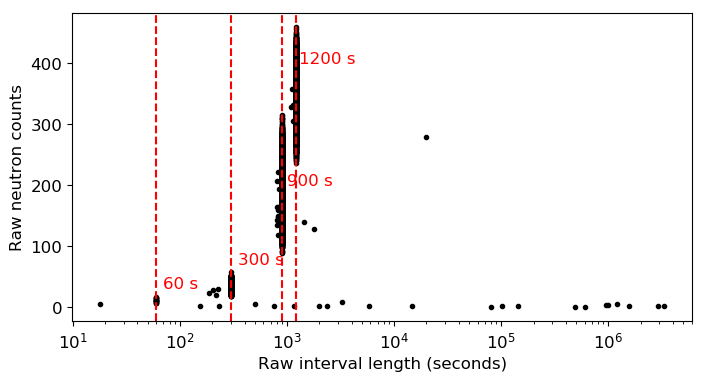

In [58]:
#plt.rc('font', **{'size'   : 14})
fig, ax = plt.subplots(figsize=(8, 4))
plt.semilogx(crns.numsecs, crns.n1c, "k.")
plt.axvline(x=1200, color="red", ls="dashed")
plt.text(1300, 400, "1200 s", color="red")
plt.axvline(x=900, color="red", ls="dashed")
plt.text(1000, 200, "900 s", color="red")
plt.axvline(x=300, color="red", ls="dashed")
plt.text(350, 70, "300 s", color="red")
plt.axvline(x=60, color="red", ls="dashed")
plt.text(70, 30, "60 s", color="red")
plt.xlabel("Raw interval length (seconds)")
plt.ylabel("Raw neutron counts")
#plt.rcdefaults()

It apears that 60, 300, 900 and 1200 seconds are intentional. Any other inerval will be considered an artefact. 

In [9]:
crns["numsecs_filt"] = crns["numsecs"]
crns.loc[~np.in1d(crns.numsecs, [60, 300, 900, 1200]), "numsecs_filt"] = np.nan

(0, 3600)

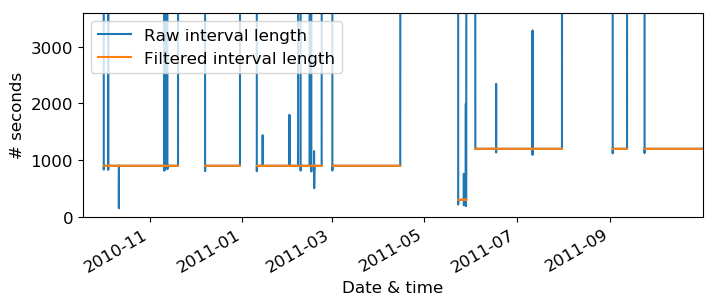

In [61]:
#plt.rc('font', **{'size'   : 14})
fig, ax = plt.subplots(figsize=(8,3))
crns.numsecs.plot(label="Raw interval length")
crns.numsecs_filt.plot(label="Filtered interval length")
plt.legend()
plt.xlabel("Date & time")
plt.ylabel("# seconds")
plt.ylim(0, 1*3600)
#plt.rcdefaults()

Now we compute the neutron count rates per second, and compute the average count rate over six hour intervals. 

Furthermore, we integrate the average neutron count rate over the six hour interval, and filter those intervals which do not have a temporal coverage of 100 percent.

In [12]:
crns["n1crate"] = crns.n1c / crns.numsecs_filt

In [35]:
interval = 6 * 3600
# Percent temporal coverage (sample seconds per target interval)
crns_6h = pd.DataFrame( {"coverage": crns.numsecs_filt.resample("6H").sum() * 100 / interval})
# Average count rate per target interval
crns_6h["n1crate"] = crns.n1crate.resample("6H").mean()
# Set those intervals to NaN which do not have full coverage
crns_6h["n1crate_filt"] = crns_6h["n1crate"]
crns_6h.loc[crns_6h.coverage < 100, "n1crate_filt"] = np.nan
# Integrate average count rate over target interval
crns_6h["n1c"] = crns_6h["n1crate_filt"] * interval

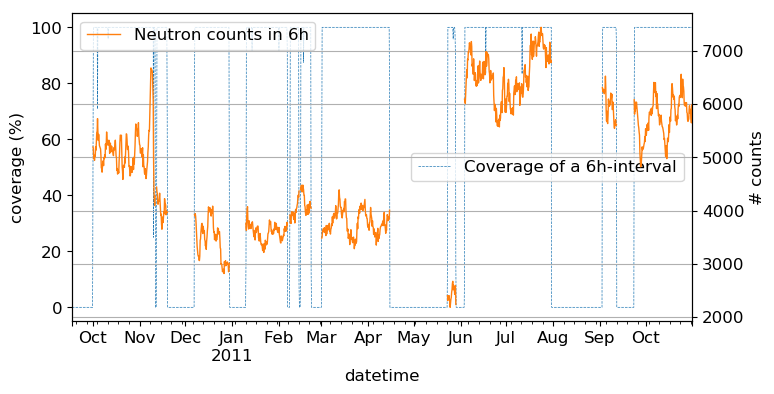

In [63]:
fig, ax = plt.subplots(figsize=(8,4))
crns_6h.coverage.plot(label="Coverage of a 6h-interval", ls="dashed", lw=0.5)
plt.ylabel("coverage (%)")
plt.legend()
crns_6h.n1c.plot(label="Neutron counts in 6h", secondary_y=True, lw=1)
plt.legend()
plt.xlabel("Date & time")
plt.ylabel("# counts")
plt.grid()